In [1]:
import pathlib
import usability
import numpy as np
import scipy

%matplotlib inline

# Determine optimal sample size – using data from the pilot study

Path to pilot study data:

In [2]:
directory = pathlib.Path("data", "pilot")

Constructing a `Sample` object, with which the data can be parsed and analyzed:

In [3]:
sample = usability.Sample(directory)

### First glance: statistical power

Here, at a significance level of $\alpha = 0.1$, varying sample sizes are plotted in relation to the statistical power for each data set. In the legend, Cohen’s $d$ is given as the effect size.

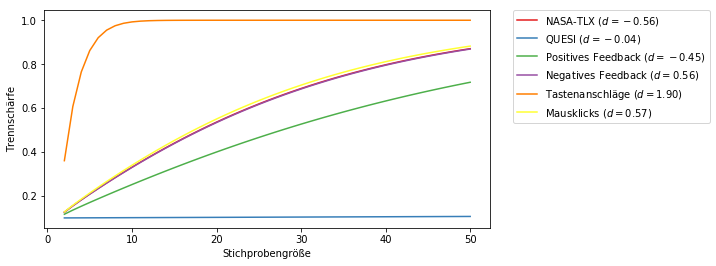

In [4]:
fig = sample.plot_power(alpha=0.1, sample_sizes=np.array(range(2, 51)))

Although not much significance may be given to the result with a sample size of only 2, we want $power > 0.5$.

Finally, calling the `optimal_size()` method to calculate optimal sample sizes for each data collection and returning the median. 

In [5]:
result = sample.optimal_size(alpha=0.1, power=0.6)
result["median size"]

23.846392841168644

# Statistical testing
## Inspecting the data

In [6]:
directory = pathlib.Path("data", "collection")
sample = usability.Sample(directory)

### Pre-questionnaire

In [7]:
sample.pre

,alter,beschäftigung,bildungsabschluss,geschlecht,pseudonym,vorkenntnisse
0,20,MCS,Gymnasium (Abitur),weiblich,ENPANO,nein
1,22,MCS,Gymnasium (Abitur),männlich,AIGÖAU,nein
2,20,Mensch-Computer-Systeme,Gymnasium (Abitur),männlich,ELCADE,nein
3,19,Mensch-Computer-Systeme Student,Gymnasium (Abitur),männlich,LDELJA,nein
4,24,Digital Humanities,Universitäts-/Hochschulabschluss,weiblich,ERALDE,spreadshirt.de
5,20,Chemie Bachelor,Gymnasium (Abitur),männlich,ASWEAP,nein
6,20,Mensch-Computer-Systeme,Gymnasium (Abitur),weiblich,RDWAJA,n. a.
7,36,digital humanities,Universitäts-/Hochschulabschluss,männlich,ANWOAU,nein
8,35,Mensch-Computer-Systeme,Universitäts-/Hochschulabschluss,weiblich,DHCHSE,spreadshirt.de
9,20,MCS,Gymnasium (Abitur),männlich,RLSCNO,nein


### NASA-TLX

In [8]:
sample.nasa

,pseudonym,score,survey,website
0,ENPANO,9.166667,nasa,spreadshirt
1,ENPANO,10.833333,nasa,shirtinator
2,AIGÖAU,26.666667,nasa,spreadshirt
3,AIGÖAU,42.500000,nasa,shirtinator
4,ELCADE,15.000000,nasa,spreadshirt
5,ELCADE,13.333333,nasa,shirtinator
6,LDELJA,47.500000,nasa,spreadshirt
7,LDELJA,39.166667,nasa,shirtinator
8,ERALDE,8.333333,nasa,spreadshirt
9,ERALDE,5.000000,nasa,shirtinator


### QUESI

In [9]:
sample.quesi

,pseudonym,score,survey,website
0,ENPANO,4.4,quesi,shirtinator
1,ENPANO,4.5,quesi,spreadshirt
2,AIGÖAU,1.9,quesi,shirtinator
3,AIGÖAU,3.9,quesi,spreadshirt
4,ELCADE,3.9,quesi,shirtinator
5,ELCADE,3.8,quesi,spreadshirt
6,LDELJA,3.5,quesi,shirtinator
7,LDELJA,2.6,quesi,spreadshirt
8,ERALDE,4.8,quesi,shirtinator
9,ERALDE,4.6,quesi,spreadshirt


### Feedback

In [10]:
sample.feedback

,negativ,positiv,pseudonym,website
0,2,3,ENPANO,spreadshirt
1,5,1,ENPANO,shirtinator
2,8,18,AIGÖAU,spreadshirt
3,21,8,AIGÖAU,shirtinator
4,5,12,ELCADE,spreadshirt
5,6,7,ELCADE,shirtinator
6,6,3,LDELJA,spreadshirt
7,2,4,LDELJA,shirtinator
8,5,6,ERALDE,spreadshirt
9,0,10,ERALDE,shirtinator


### Keyboard strokes

In [11]:
sample.keyboard

,pseudonym,tastenanschläge,website
0,ENPANO,37,shirtinator
1,ENPANO,30,spreadshirt
2,AIGÖAU,56,shirtinator
3,AIGÖAU,41,spreadshirt
4,ELCADE,16,shirtinator
5,ELCADE,18,spreadshirt
6,LDELJA,39,shirtinator
7,LDELJA,35,spreadshirt
8,ERALDE,17,shirtinator
9,ERALDE,52,spreadshirt


### Mouse clicks

In [12]:
sample.mouse

,clicks,pseudonym,website
0,101,ENPANO,shirtinator
1,112,ENPANO,spreadshirt
2,132,AIGÖAU,shirtinator
3,88,AIGÖAU,spreadshirt
4,96,ELCADE,shirtinator
5,105,ELCADE,spreadshirt
6,107,LDELJA,shirtinator
7,165,LDELJA,spreadshirt
8,100,ERALDE,shirtinator
9,119,ERALDE,spreadshirt


## Check prerequisites for t-test

### 1. Normal distribution

In [13]:
ALPHA = 0.05

collections = [sample.nasa, sample.quesi, sample.feedback,
               sample.feedback, sample.keyboard, sample.mouse]
columns = ["score", "score", "positiv", "negativ", "tastenanschläge", "clicks"]

for column, data in zip(columns, collections):
    print(f"Analyzing {data.name}\n")
    
    x = data[data["website"] == "spreadshirt"][column]
    y = data[data["website"] == "shirtinator"][column]
          
    # Shapiro-Wilk Test
    print("SPREADSHIRT")
    print("-----------\n")
    stat, p = scipy.stats.shapiro(x)
    print(f"Statistics={round(stat, 3)}, p={round(p, 3)}\n")
    print("+++++++++++++++++++++++++++++++++++++++++")
    if p > ALPHA:
        print("Sample looks Gaussian (fail to reject H0)")
    else:
        print("Sample does not look Gaussian (reject H0)")
    print("+++++++++++++++++++++++++++++++++++++++++\n\n")
    
    print("SHIRTINATOR")
    print("-----------\n")
    stat, p = scipy.stats.shapiro(y)
    print(f"Statistics={round(stat, 3)}, p={round(p, 3)}\n")
    print("+++++++++++++++++++++++++++++++++++++++++")
    if p > ALPHA:
        print("Sample looks Gaussian (fail to reject H0)")
    else:
        print("Sample does not look Gaussian (reject H0)")
    print("+++++++++++++++++++++++++++++++++++++++++\n")
    print("#########################################\n")

Analyzing NASA-TLX

SPREADSHIRT
-----------

Statistics=0.942, p=0.163

+++++++++++++++++++++++++++++++++++++++++
Sample looks Gaussian (fail to reject H0)
+++++++++++++++++++++++++++++++++++++++++


SHIRTINATOR
-----------

Statistics=0.923, p=0.061

+++++++++++++++++++++++++++++++++++++++++
Sample looks Gaussian (fail to reject H0)
+++++++++++++++++++++++++++++++++++++++++

#########################################

Analyzing QUESI

SPREADSHIRT
-----------

Statistics=0.962, p=0.463

+++++++++++++++++++++++++++++++++++++++++
Sample looks Gaussian (fail to reject H0)
+++++++++++++++++++++++++++++++++++++++++


SHIRTINATOR
-----------

Statistics=0.944, p=0.188

+++++++++++++++++++++++++++++++++++++++++
Sample looks Gaussian (fail to reject H0)
+++++++++++++++++++++++++++++++++++++++++

#########################################

Analyzing Feedback

SPREADSHIRT
-----------

Statistics=0.391, p=0.0

+++++++++++++++++++++++++++++++++++++++++
Sample does not look Gaussian (reject H0)
+++++

### 2. Homogeneity of variances

In [14]:
for column, data in zip(columns, collections):
    print(f"Analyzing {data.name}\n")
    
    x = data[data["website"] == "spreadshirt"][column]
    y = data[data["website"] == "shirtinator"][column]
          
    # Shapiro-Wilk Test
    print("SPREADSHIRT")
    print("-----------\n")
    stat, p = scipy.stats.levene(x, y)
    print(f"Statistics={round(stat, 3)}, p={round(p, 3)}\n")
    print("+++++++++++++++++++++++++++++++++++++++++")
    if p > ALPHA:
        print("Variances look homogeneous (fail to reject H0)")
    else:
        print("Variances do not look homogeneous (reject H0)")
    print("+++++++++++++++++++++++++++++++++++++++++\n")

Analyzing NASA-TLX

SPREADSHIRT
-----------

Statistics=0.405, p=0.528

+++++++++++++++++++++++++++++++++++++++++
Variances look homogeneous (fail to reject H0)
+++++++++++++++++++++++++++++++++++++++++

Analyzing QUESI

SPREADSHIRT
-----------

Statistics=0.07, p=0.792

+++++++++++++++++++++++++++++++++++++++++
Variances look homogeneous (fail to reject H0)
+++++++++++++++++++++++++++++++++++++++++

Analyzing Feedback

SPREADSHIRT
-----------

Statistics=0.583, p=0.449

+++++++++++++++++++++++++++++++++++++++++
Variances look homogeneous (fail to reject H0)
+++++++++++++++++++++++++++++++++++++++++

Analyzing Feedback

SPREADSHIRT
-----------

Statistics=4.874, p=0.032

+++++++++++++++++++++++++++++++++++++++++
Variances do not look homogeneous (reject H0)
+++++++++++++++++++++++++++++++++++++++++

Analyzing Keyboard

SPREADSHIRT
-----------

Statistics=0.049, p=0.826

+++++++++++++++++++++++++++++++++++++++++
Variances look homogeneous (fail to reject H0)
++++++++++++++++++++++++++++

## t-test

In [15]:
stat, p = scipy.stats.ttest_ind(x, y)
print(f"Statistics={round(stat, 3)}, p={round(p, 3)}\n")
if p > ALPHA:
    print("Means are equal.")
else:
    print("Means are not equal.")

Statistics=0.955, p=0.344

Means are equal.
